### Load the libs

I will use a lot of fastai tools which make a lot of tasks much easier than using only pytorch

In [553]:
from fastai.text import *
import html
from pathlib import Path

In [554]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/reddit/classifier')
PATH.mkdir(exist_ok=True)

### Get the data from reddit

In [159]:
#might take about 10 min to run this
from collections import Counter
from psaw import PushshiftAPI
api = PushshiftAPI()

gen = api.search_submissions(limit=200000,subreddit='science',filter=['title','link_flair_text'])
submissions=list(gen)

(list_topic,list_title)=([],[])

for submission in submissions:
    try:
        if not(submission[-1]['link_flair_text']==None):
            list_topic.append(submission[-1]['link_flair_text'])
            list_title.append(submission[-1]['title'])
    except:
        pass
len(list_topic)

101203

In [171]:
list_topic[:4]

['Anthropology', 'Anthropology', 'Physics', 'Neuroscience']

In [178]:
all_texts, all_labels_txt = np.array(list_title),np.array(list_topic)

all_labels_txt[-10:]

array(['Animal Science', 'Astronomy', 'Astronomy', 'Health', 'Neuroscience', 'Animal Science', 'Astronomy',
       'Anthropology', 'Physics', 'Medicine'], dtype='<U64')

## Standardize format

In [179]:
CLAS_PATH=Path('data/reddit/clas') #path for data for classification model
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/reddit/lm') #path for data for language model
LM_PATH.mkdir(exist_ok=True)

In [201]:
#check for wrong labels
unique, counts = np.unique(all_labels_txt, return_counts=True)

In [203]:
len(unique)

786

Quick look at the data shows that there is a whole bunch of categories which occurs only once or few times
I will remove such infrequent categories

In [204]:
[(lab,ct) for (lab, ct) in zip(unique, counts) if ct>50]

[('Animal Science', 5474),
 ('Anthropology', 2154),
 ('Astronomy', 6256),
 ('Biology', 11301),
 ('Cancer', 2488),
 ('Chemistry', 2388),
 ('Computer Sci', 465),
 ('Computer Science', 2833),
 ('Earth Science', 3275),
 ('Engineering', 4409),
 ('Environment', 8072),
 ('Epidemiology', 1339),
 ('Geology', 1574),
 ('Health', 12549),
 ('Mathematics', 622),
 ('Medicine', 8779),
 ('Nanoscience', 1276),
 ('Neuroscience', 5981),
 ('Paleontology', 1902),
 ('Physics', 5529),
 ('Psychology', 6631),
 ('Social Science', 4020),
 ('Social Sciences', 686)]

In [246]:
#let's also merge Computer Sci/Computer Science and Social Sciences/Social Science
#and build a dict for it
toint_tmp = {lab:n for n, (lab, ct) in enumerate(zip(unique, counts)) if ct>50}
#change the value for merged classes
toint_tmp['Computer Sci'] = toint_tmp['Computer Science']
toint_tmp['Social Sciences'] = toint_tmp['Social Science']

In [256]:
#renumerate the int labels and build the dict with a default value
enum_dict = {m:n for n, m in enumerate(set(toint_tmp.values()))}
class_toint = collections.defaultdict(lambda:-1, {k:enum_dict[v] for (k,v) in toint_tmp.items()})
class_toint

defaultdict(<function __main__.<lambda>()>,
            {'Animal Science': 4,
             'Anthropology': 5,
             'Astronomy': 10,
             'Biology': 13,
             'Cancer': 20,
             'Chemistry': 0,
             'Computer Sci': 6,
             'Computer Science': 6,
             'Earth Science': 15,
             'Engineering': 17,
             'Environment': 18,
             'Epidemiology': 19,
             'Geology': 7,
             'Health': 12,
             'Mathematics': 3,
             'Medicine': 8,
             'Nanoscience': 14,
             'Neuroscience': 16,
             'Paleontology': 1,
             'Physics': 9,
             'Psychology': 11,
             'Social Science': 2,
             'Social Sciences': 2})

In [257]:
CLASSES = list(class_toint.keys())

In [258]:
#change text labels to numbers
#text labels which are not in dictionary will get -1 - these will be removed later
all_labels = np.array([class_toint[i] for i in all_labels_txt])

In [259]:
#check if imported arrays looks good
all_labels.shape, all_texts.shape

((101203,), (101203,))

In [260]:
col_names = ['labels','text']

In [267]:
all_data_df = pd.DataFrame({'text':all_texts, 'labels':all_labels,}, columns=col_names)
#remove duplicates
print('duplicates:', np.sum(all_data_df.duplicated(subset=col_names[1])))
all_data_df = all_data_df.drop_duplicates(subset=col_names[1])
print('duplicates:', np.sum(all_data_df.duplicated(subset=col_names[1])))

duplicates: 3172
duplicates: 0


In [268]:
all_data_df.shape

(98031, 2)

In [269]:
#remove not frequent classes
all_data_df = all_data_df.loc[all_data_df['labels']!=-1]
all_data_df.shape

(96864, 2)

Let's split the data to train and test datasets.

In [270]:
df_trn, df_val = sklearn.model_selection.train_test_split(
                all_data_df.iloc[:,:2], test_size=0.1, random_state=11)


print(f'df_trn_lm: {df_trn.shape}')
print(f'df_val_lm: {df_val.shape}')
assert(df_trn.shape[0]+df_val.shape[0]==all_data_df.shape[0])

df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

df_trn_lm: (87177, 2)
df_val_lm: (9687, 2)


In [271]:
#save the data for classification model
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

#### Prepare data for LM

I need LM to use it as a enocoding part for the clasifier. Since we don't use actual classifier labels let append the labels with 0.

In [272]:
df_trn_lm, df_val_lm = df_trn.copy(), df_val.copy()

df_trn_lm['labels'] = 0
df_val_lm['labels'] = 0

print(f'df_trn_lm: {df_trn_lm.shape}')
print(f'df_val_lm: {df_val_lm.shape}')
assert(df_trn_lm.shape[0]+df_val_lm.shape[0]==all_data_df.shape[0])

df_trn_lm.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val_lm.to_csv(LM_PATH/'test.csv', header=False, index=False)

df_trn_lm: (87177, 2)
df_val_lm: (9687, 2)


In [273]:
df_trn_lm.head()

,labels,text
4588,0,Combining antibiotics changes their effectiveness
79078,0,Don't take ibuprofen everyday...
13594,0,Meaning of Android.
38742,0,For Germany to run on 100% intermittent renewa...
9159,0,Human stem cell treatment cures alcoholism in ...


## Language model tokens

The section for cleaning and tokenizing the text.
Use spacy tokenizer with fastai implementation which allow to use multiple cores.

In [274]:
chunksize=24000

In [275]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [276]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [277]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [278]:
df_trn_lm = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val_lm = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [279]:
tok_trn, trn_labels = get_all(df_trn_lm, 1)
tok_val, val_labels = get_all(df_val_lm, 1)

0
1
2
3
0


Save the numpy arrays to the tmp directory

In [280]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [281]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [282]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [283]:
#check most frequent tokens
freq = Counter(p for dt in [tok_trn,tok_val] for o in dt for p in o)
freq.most_common(25)

[('1', 97703),
 ('\n', 96865),
 ('xbos', 96864),
 ('xfld', 96864),
 ('the', 57619),
 ('of', 50944),
 (',', 45780),
 ('.', 39474),
 ('to', 39225),
 ('in', 37823),
 ('a', 37422),
 ('-', 30936),
 ('and', 30865),
 ('t_up', 19895),
 ('that', 16808),
 ('for', 14672),
 ('new', 14227),
 ('study', 13049),
 ('with', 11205),
 (':', 11056),
 ('is', 11008),
 ('on', 9874),
 ('have', 9208),
 ('from', 8344),
 ('are', 8215)]

It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set maz_vocab to 60000.

In [284]:
max_vocab = 60000
#let's set up min_freq to 1 so we can have some data from lm even for single word occurance
min_freq = 1

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [286]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

30618

In [287]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [288]:
#save it to disk in case of crush
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [289]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [290]:
vs=len(itos)
vs,len(trn_lm),len(val_lm)

(30618, 87177, 9687)

## Language Model

Use of pretrained english models as a backbone for our classifier. Usually it was done by using just word embedings, but current researches shows that pretrained and finetuned model gives better results.

Source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. [Link to dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
The language model for wikitext103 has been pre-trained. Fastai reserchers provided pretrained weights for such language models. Weights can be found here: http://files.fast.ai/models/wt103/

This model will be also finetuned on reddit text

Let's try to finetune both backward and forward model.

Note: Using LM instead of encodings shine in the situations where context and order of the words matter a lot (i.e. sentiment analysis). It might not be a case for reddit title classification.

### Forward - wikitext103 conversion

In [291]:
em_sz,nh,nl = 400,1150,3

In [292]:
PRE_PATH = PATH/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [293]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

#let's remove items from wikitext which are not used in reddit data # save the memory
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

Now overwrite the weights into the wgts odict.
The decoder module is also loaded with the same weights due to an idea called weight tying.

In [294]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

### Forward - Language model

In [295]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [296]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [297]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) * 1.

First tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So
freeze everything except the last layer.

In [298]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [299]:
learner.model.load_state_dict(wgts)

In [300]:
lr=1e-3
lrs = lr

In [301]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      5.431178   5.008638   0.293273  



[array([5.00864]), 0.2932733808954557]

In [302]:
learner.unfreeze()

In [303]:
learner.lr_find(wds = wd, start_lr=lrs/100, end_lr=lrs*100, linear=True)

epoch      trn_loss   val_loss   accuracy                   
    0      6.862496   6.777432   0.202682  



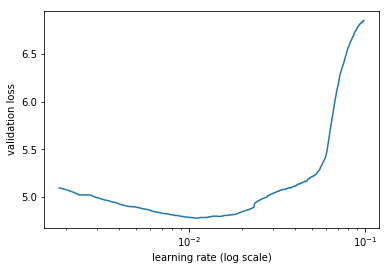

In [304]:
learner.sched.plot()

In [305]:
#looking at LR finder output 1e-2 looks like a good candidate - loss is still decreasing at this level
lr=1e-2
lrs = lr
learner.fit(lrs, 1, wds=wd, cycle_len=30, use_clr_beta=(20,20,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      4.389402   4.115833   0.355276  
    1      4.134708   3.985045   0.363533                   
    2      3.990384   3.952707   0.365828                   
    3      3.90764    3.953436   0.365551                   
    4      3.877955   3.962528   0.36296                    
    5      3.895111   3.981689   0.362648                   
    6      3.879052   4.025608   0.358627                   
    7      3.912795   4.056767   0.3554                     
    8      3.96583    4.069415   0.354376                   
    9      3.984305   4.111322   0.351242                   
    10     4.007014   4.138292   0.349872                   
    11     4.052738   4.147307   0.348471                   
    12     4.021982   4.139831   0.34851                    
    13     3.945869   4.119946   0.350548                   
    14     3.868998   4.100065   0.353475                   
    15     3.793504   4.077083   0.355236

[array([4.01748]), 0.36994562049706775]

In [306]:
learner.save('lmorg')
learner.save_encoder('lmorg_enc')

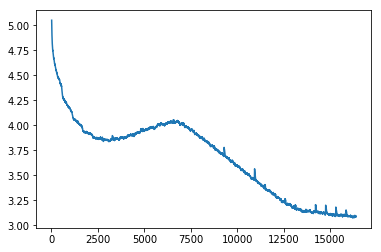

In [307]:
learner.sched.plot_loss()

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. 
Let's first load the tokens for the model

In [308]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [309]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
0


In [310]:
len(tok_trn)

87177

In [311]:

(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [312]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [313]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(stoi)

30618

In [314]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [315]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Simple Classifier

In this step let's build a simple classifier which is just taking average encodings (not LM) as an input to classifier

In [316]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [317]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [318]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 256

In [319]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [320]:
lengths = np.vectorize(len)(trn_clas)

In [321]:
len(np.where(lengths>70)[0])

17

In the classifier, unlike LM, we need to read a title at a time and learn to predict the label. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To not pad too much, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury). Good things in a reddit data is that only few obs have more than 70 tokens (bptt parameter).


In [495]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [496]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 1. #*0.5

In [497]:
class Simple_Classifier(nn.Module):
    def __init__(self, bptt, max_seq, n_class, n_tok, emb_sz, n_hid, n_layers, pad_token, layers, drops, bidir=False,
                      dropouth=0.3, dropouti=0.5, dropoute=0.1, wdrop=0.5, qrnn=False):
        super().__init__()
        self.encoder = nn.Embedding(n_tok, emb_sz, padding_idx=pad_token)
        self.encoder_with_dropout = EmbeddingDropout(self.encoder)
        self.layers = nn.ModuleList([
            LinearBlock(layers[i], layers[i + 1], drops[i]) for i in range(len(layers) - 1)])
        self.encoder.weight.data.uniform_(-0.1, 0.1)
        self.emb_sz,self.nhid,self.nlayers,self.dropoute = emb_sz,n_hid,n_layers,dropoute
        self.dropouti = LockedDropout(dropouti)
        

    def pool(self, x, bs, is_max):
        f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
        return f(x.permute(1,2,0), (1,)).view(bs,-1)
    
    def forward(self, input):
        emb = self.encoder_with_dropout(input, dropout=self.dropoute if self.training else 0)
        outputs1 = self.dropouti(emb)
        sl,bs,_ = outputs1.size()
        
        avgpool1 = self.pool(outputs1, bs, False)
        mxpool1 = self.pool(outputs1, bs, True)
        
        #input to the classifier
        x = torch.cat([mxpool1, avgpool1], 1)
        #x = torch.cat([cl], 1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return l_x, outputs1, outputs1


class TextModel(BasicModel):
    def get_layer_groups(self):
        m = self.model
        return [(m.encoder, m.dropouti), (m.layers)]


In [513]:
m = Simple_Classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*2, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [514]:
#Lets create a learner object
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=0.3

metrics = [accuracy]
learn.metrics = metrics

In [515]:
#summary of the model
#print(m)
for name, param in learn.model.state_dict().items():
    print(name, param.shape)

encoder.weight torch.Size([30618, 400])
encoder_with_dropout.embed.weight torch.Size([30618, 400])
layers.0.lin.weight torch.Size([50, 800])
layers.0.lin.bias torch.Size([50])
layers.0.bn.weight torch.Size([800])
layers.0.bn.bias torch.Size([800])
layers.0.bn.running_mean torch.Size([800])
layers.0.bn.running_var torch.Size([800])
layers.1.lin.weight torch.Size([21, 50])
layers.1.lin.bias torch.Size([21])
layers.1.bn.weight torch.Size([50])
layers.1.bn.bias torch.Size([50])
layers.1.bn.running_mean torch.Size([50])
layers.1.bn.running_var torch.Size([50])


In [516]:
#Fastai practitioners suggest to use different lr for different part of the model
#lrs=np.array([5e-5,5e-5,2e-4,5e-4,1e-3])
lrs=np.array([2e-3,5e-3]) 
#lrs=5e-3
wd = 1e-7

In [517]:
#layer groups can be found using following
#there is 2 layer groups in this model
list(enumerate(learn.get_layer_groups()))

[(0, (Embedding(30618, 400, padding_idx=1), LockedDropout(
   ))), (1, ModuleList(
    (0): LinearBlock(
      (lin): Linear(in_features=800, out_features=50, bias=True)
      (drop): Dropout(p=0.4)
      (bn): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): LinearBlock(
      (lin): Linear(in_features=50, out_features=21, bias=True)
      (drop): Dropout(p=0.1)
      (bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
    )
  ))]

In [518]:
#load the pretrain weights to the encoders
wgts = torch.load(PATH/'models/lmorg_enc.h5', map_location=lambda storage, loc: storage)

In [519]:
learn.model.encoder.weight.data = to_gpu(wgts['encoder.weight'])
learn.model.encoder_with_dropout.embed.weight.data = to_gpu(wgts['encoder_with_dropout.embed.weight'])

In [520]:
learn.freeze_to(-1)

epoch      trn_loss   val_loss   accuracy                    
    0      2.319294   1.868578   0.393628  


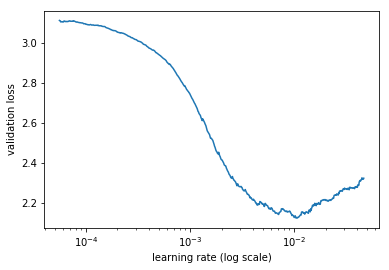

In [521]:
learn.lr_find(lrs/100, lrs*10)
learn.sched.plot()

lr=2e-3
lrm = 5.
lrs = np.array([lr/(lrm**2), lr/(lrm**2), lr/(lrm**2), lr/lrm, lr])
lrs

In [522]:
#lrs=np.array([1e-5,1e-5,5e-5,1e-4,5e-4])

In [523]:
#let's run 2 epoch only training the fc layers
learn.fit(lrs, 1, wds=wd, cycle_len=2, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      2.118459   1.693038   0.471147  
    1      2.078544   1.649129   0.481883                    


[array([1.64913]), 0.4818829356965677]

In [524]:
#learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3)) #0.62

In [525]:
learn.save('clas_0')

In [528]:
learn.load('clas_0')

In [529]:
learn.unfreeze()
learn.fit(lrs, 1, wds=wd, cycle_len=12, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      1.845537   1.556105   0.500774  
    1      1.752502   1.483644   0.522453                    
    2      1.663126   1.447569   0.53164                     
    3      1.608864   1.433825   0.534118                    
    4      1.486385   1.419428   0.547125                    
    5      1.421752   1.406606   0.549499                    
    6      1.366691   1.457277   0.551977                    
    7      1.324294   1.433702   0.551874                    
    8      1.283839   1.424113   0.553525                    
    9      1.301649   1.424583   0.552906                    
    10     1.236906   1.417661   0.555487                    
    11     1.200196   1.443055   0.555074                    


[array([1.44306]), 0.5550738104734552]

### LM Classifier

Let's try to do sth more complocated and check if applying LM as an input to classifier helps with the accuracy. In details as an input for classifier I will use avgpool and maxpool of the outputs and hidden state of the LM.

In [608]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [609]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 0.7 #*0.5

In [612]:

#modify this fastai class to ouput also hidden state
class RNN_Encoder(nn.Module):

    """A custom RNN encoder network that uses
        - an embedding matrix to encode input,
        - a stack of LSTM or QRNN layers to drive the network, and
        - variational dropouts in the embedding and LSTM/QRNN layers

        The architecture for this network was inspired by the work done in
        "Regularizing and Optimizing LSTM Language Models".
        (https://arxiv.org/pdf/1708.02182.pdf)
    """

    initrange=0.1

    def __init__(self, ntoken, emb_sz, nhid, nlayers, pad_token, bidir=False,
                 dropouth=0.3, dropouti=0.65, dropoute=0.1, wdrop=0.5, qrnn=False, bias=False):
        """ Default constructor for the RNN_Encoder class

            Args:
                bs (int): batch size of input data
                ntoken (int): number of vocabulary (or tokens) in the source dataset
                emb_sz (int): the embedding size to use to encode each token
                nhid (int): number of hidden activation per LSTM layer
                nlayers (int): number of LSTM layers to use in the architecture
                pad_token (int): the int value used for padding text.
                dropouth (float): dropout to apply to the activations going from one LSTM layer to another
                dropouti (float): dropout to apply to the input layer.
                dropoute (float): dropout to apply to the embedding layer.
                wdrop (float): dropout used for a LSTM's internal (or hidden) recurrent weights.

            Returns:
                None
          """

        super().__init__()
        self.ndir = 2 if bidir else 1
        self.bs, self.qrnn = 1, qrnn
        self.encoder = nn.Embedding(ntoken, emb_sz, padding_idx=pad_token)
        self.encoder_with_dropout = EmbeddingDropout(self.encoder)
        if self.qrnn:
            #Using QRNN requires cupy: https://github.com/cupy/cupy
            from .torchqrnn.qrnn import QRNNLayer
            self.rnns = [QRNNLayer(emb_sz if l == 0 else nhid, (nhid if l != nlayers - 1 else emb_sz)//self.ndir,
                save_prev_x=True, zoneout=0, window=2 if l == 0 else 1, output_gate=True) for l in range(nlayers)]
            if wdrop:
                for rnn in self.rnns:
                    rnn.linear = WeightDrop(rnn.linear, wdrop, weights=['weight'])
        else:
            self.rnns = [nn.LSTM(emb_sz if l == 0 else nhid, (nhid if l != nlayers - 1 else emb_sz)//self.ndir,
                1, bidirectional=bidir) for l in range(nlayers)]
            if wdrop: self.rnns = [WeightDrop(rnn, wdrop) for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)

        self.emb_sz,self.nhid,self.nlayers,self.dropoute = emb_sz,nhid,nlayers,dropoute
        self.dropouti = LockedDropout(dropouti)
        self.dropouths = nn.ModuleList([LockedDropout(dropouth) for l in range(nlayers)])

    def forward(self, input):
        """ Invoked during the forward propagation of the RNN_Encoder module.
        Args:
            input (Tensor): input of shape (sentence length x batch_size)

        Returns:
            raw_outputs (tuple(list (Tensor), list(Tensor)): list of tensors evaluated from each RNN layer without using
            dropouth, list of tensors evaluated from each RNN layer using dropouth,
        """
        sl,bs = input.size()
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        with set_grad_enabled(self.training):
            emb = self.encoder_with_dropout(input, dropout=self.dropoute if self.training else 0)
            emb = self.dropouti(emb)
            raw_output = emb
            new_hidden,raw_outputs,outputs = [],[],[]
            for l, (rnn,drop) in enumerate(zip(self.rnns, self.dropouths)):
                current_input = raw_output
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    raw_output, new_h = rnn(raw_output, self.hidden[l])
                new_hidden.append(new_h)
                raw_outputs.append(raw_output)
                if l != self.nlayers - 1: raw_output = drop(raw_output)
                outputs.append(raw_output)
            self.hidden = repackage_var(new_hidden)
        return raw_outputs, outputs, new_hidden

    def one_hidden(self, l):
        nh = (self.nhid if l != self.nlayers - 1 else self.emb_sz)//self.ndir
        if IS_TORCH_04: return Variable(self.weights.new(self.ndir, self.bs, nh).zero_())
        else: return Variable(self.weights.new(self.ndir, self.bs, nh).zero_(), volatile=not self.training)

    def reset(self):
        if self.qrnn: [r.reset() for r in self.rnns]
        self.weights = next(self.parameters()).data
        if self.qrnn: self.hidden = [self.one_hidden(l) for l in range(self.nlayers)]
        else: self.hidden = [(self.one_hidden(l), self.one_hidden(l)) for l in range(self.nlayers)]
            
#modify this fastai class to ouput also hidden state           
class MultiBatchRNN(RNN_Encoder):
    def __init__(self, bptt, max_seq, *args, **kwargs):
        self.max_seq,self.bptt = max_seq,bptt
        super().__init__(*args, **kwargs)

    def concat(self, arrs):
        return [torch.cat([l[si] for l in arrs]) for si in range(len(arrs[0]))]

    def forward(self, input):
        sl,bs = input.size()
        for l in self.hidden:
            for h in l: h.data.zero_()
        raw_outputs, outputs = [],[]
        for i in range(0, sl, self.bptt):
            r, o, h = super().forward(input[i: min(i+self.bptt, sl)])
            if i>(sl-self.max_seq):
                raw_outputs.append(r)
                outputs.append(o)
        return self.concat(raw_outputs), self.concat(outputs), h


#create a class which will take as an input two rnns and on top of that will create classifier
class LM_Classifier(nn.Module):
    def __init__(self, bptt, max_seq, n_class, n_tok, emb_sz, n_hid, n_layers, pad_token, layers, drops, bidir=False,
                      dropouth=0.3, dropouti=0.5, dropoute=0.1, wdrop=0.5, qrnn=False):
        super().__init__()
        self.rnn1 = MultiBatchRNN(bptt, max_seq, n_tok, emb_sz, n_hid, n_layers, pad_token=pad_token, bidir=bidir,
                      dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop, qrnn=qrnn)
        self.layers = nn.ModuleList([
            LinearBlock(layers[i], layers[i + 1], drops[i]) for i in range(len(layers) - 1)])
        self.rnn1.reset()
        

    def pool(self, x, bs, is_max):
        f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
        return f(x.permute(1,2,0), (1,)).view(bs,-1)
    
    def forward(self, input):
        raw_outputs1, outputs1, hiddens1 = self.rnn1(input)
        sl,bs,_ = outputs1[-1].size()
        cell1= hiddens1[-1][0].permute(1,2,0).view(bs,-1)
        output1 = outputs1[-1]
        avgpool1 = self.pool(output1, bs, False)
        mxpool1 = self.pool(output1, bs, True)
        
        #input to the classifier
        x = torch.cat([cell1, mxpool1, avgpool1], 1)
        #x = torch.cat([cl], 1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return l_x, raw_outputs1, outputs1

class TextModel(BasicModel):
    def get_layer_groups(self):
        m = self.model
        return [(m.rnn1.encoder, m.rnn1.dropouti), 
                *zip(m.rnn1.rnns, m.rnn1.dropouths), (m.layers)]


In [613]:
m = LM_Classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [614]:
#Lets create a learner object
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=0.3

metrics = [accuracy]
learn.metrics = metrics

In [615]:
#Fastai practitioners suggest to use different lr for different part of the model
#lrs=np.array([5e-5,5e-5,2e-4,5e-4,1e-3])
lrs=np.array([2e-4,2e-4,1e-3,2e-3,5e-3]) 
#lrs=5e-3
wd = 1e-7

In [617]:
#load the pretrain weights to the encoders
wgts = torch.load(PATH/'models/lmorg_enc.h5', map_location=lambda storage, loc: storage)
learn.model.rnn1.load_state_dict(wgts)


In [618]:
learn.freeze_to(-1)

epoch      trn_loss   val_loss   accuracy                     
    0      1.929422   1.617986   0.470855  


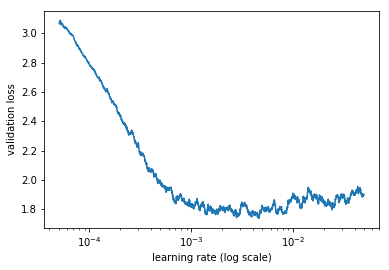

In [619]:
learn.lr_find(lrs/100, lrs*10)
learn.sched.plot()

lr=2e-3
lrm = 5.
lrs = np.array([lr/(lrm**2), lr/(lrm**2), lr/(lrm**2), lr/lrm, lr])
lrs

In [620]:
#I will set up earlier layers a bit lower
lrs=np.array([2e-4,2e-4,2e-4,5e-4,1e-3])

In [621]:
learn.fit(lrs, 1, wds=wd, cycle_len=2, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.706613   1.517611   0.501807  
    1      1.718591   1.476003   0.516672                     


[array([1.476]), 0.5166718281549394]

In [622]:
learn.save('clas_0')

In [623]:
learn.load('clas_0')

In [624]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=wd, cycle_len=4, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.5961     1.453188   0.521008  
    1      1.6115     1.437246   0.525446                     
    2      1.540945   1.416926   0.532363                     
    3      1.538087   1.412703   0.533086                     


[array([1.4127]), 0.5330855803633605]

In [625]:
learn.freeze_to(-3)
learn.fit(lrs, 1, wds=wd, cycle_len=4, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.539202   1.398804   0.533086  
    1      1.531173   1.384925   0.539796                     
    2      1.484101   1.3717     0.545267                     
    3      1.451563   1.365574   0.547435                     


[array([1.36557]), 0.5474347087363408]

In [626]:
#oryginal lm - 0.64

In [627]:
learn.save('clas_1')

In [628]:
learn.load('clas_1')

In [629]:
learn.unfreeze()

In [630]:
learn.fit(lrs, 1, wds=wd, cycle_len=8, use_clr_beta=(10,10,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                     
    0      1.405376   1.364382   0.548983  
    1      1.371967   1.354149   0.550222                     
    2      1.486945   1.359936   0.550635                     
    3      1.431006   1.349027   0.557345                     
    4      1.374764   1.348864   0.555693                     
    5      1.308145   1.342138   0.559822                     
    6      1.349766   1.348333   0.558584                     
    7      1.278519   1.344164   0.560029                     


[array([1.34416]), 0.5600289045792191]

### Summary

Using LM as a backbone instead of embedings gave slightly better results. However the difference is very low which might mean that context and word order is not that important for this dataset. Second model is much more complex so it could be also a chance that parameters are not optimal and after longer tuning it could give better results.

#### Appendix - trying bidir model as an input for classifier

This model is more complex than the previous one, so it's even a bigger chance that the parameters are not optimal. In the end it didn't reach as good results as more simple ones.


### Backward - wikitext103 conversion

In [530]:
em_sz,nh,nl = 400,1150,3

In [531]:
PRE_PATH = PATH/'wt103'
PRE_LM_PATH = PRE_PATH/'bwd_wt103.h5'

In [532]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [533]:
for i in wgts.keys():
    print(i)
    print(to_np(wgts[i]).shape)

0.encoder.weight
(238462, 400)
0.encoder_with_dropout.embed.weight
(238462, 400)
0.rnns.0.module.weight_ih_l0
(4600, 400)
0.rnns.0.module.bias_ih_l0
(4600,)
0.rnns.0.module.bias_hh_l0
(4600,)
0.rnns.0.module.weight_hh_l0_raw
(4600, 1150)
0.rnns.1.module.weight_ih_l0
(4600, 1150)
0.rnns.1.module.bias_ih_l0
(4600,)
0.rnns.1.module.bias_hh_l0
(4600,)
0.rnns.1.module.weight_hh_l0_raw
(4600, 1150)
0.rnns.2.module.weight_ih_l0
(1600, 1150)
0.rnns.2.module.bias_ih_l0
(1600,)
0.rnns.2.module.bias_hh_l0
(1600,)
0.rnns.2.module.weight_hh_l0_raw
(1600, 400)
1.decoder.weight
(238462, 400)


Calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target reddit LM.

In [534]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [535]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Need to match up the vocab words and their indexes. 
Use the defaultdict container once again, to assign mean weights to unknown reddit tokens that do not exist in wikitext103.

In [536]:
#let's remove items from wikitext which are not used in reddit data # save the memory
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [537]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new reddit lm

### Backward - Language model

Let's create LM, load the prepared weights and finetune it with reddit word corpus.

In [538]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

Use fastai `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.


In [539]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt, backwards=True)

In [540]:
#below recommended dropouts by fastai

In [543]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) * 1.

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

In [544]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [545]:
for name, param in learner.model.state_dict().items():
    print(name, param.shape)

0.encoder.weight torch.Size([30618, 400])
0.encoder_with_dropout.embed.weight torch.Size([30618, 400])
0.rnns.0.module.weight_ih_l0 torch.Size([4600, 400])
0.rnns.0.module.bias_ih_l0 torch.Size([4600])
0.rnns.0.module.bias_hh_l0 torch.Size([4600])
0.rnns.0.module.weight_hh_l0_raw torch.Size([4600, 1150])
0.rnns.1.module.weight_ih_l0 torch.Size([4600, 1150])
0.rnns.1.module.bias_ih_l0 torch.Size([4600])
0.rnns.1.module.bias_hh_l0 torch.Size([4600])
0.rnns.1.module.weight_hh_l0_raw torch.Size([4600, 1150])
0.rnns.2.module.weight_ih_l0 torch.Size([1600, 1150])
0.rnns.2.module.bias_ih_l0 torch.Size([1600])
0.rnns.2.module.bias_hh_l0 torch.Size([1600])
0.rnns.2.module.weight_hh_l0_raw torch.Size([1600, 400])
1.decoder.weight torch.Size([30618, 400])


In [546]:
learner.model.load_state_dict(wgts)

We set learning rates and fit reddit LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [547]:
lr=1e-3
lrs = lr

In [548]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      7.601328   7.403744   0.110607  


[array([7.40374]), 0.11060708227256934]

In [549]:
#unfreeze whole net to train it
learner.unfreeze()

In [550]:
#try to find good candidate for lr
learner.lr_find(wds = wd, start_lr=lrs/100, end_lr=lrs*100, linear=True)

epoch      trn_loss   val_loss   accuracy                   
    0      6.722415   6.601679   0.210695  


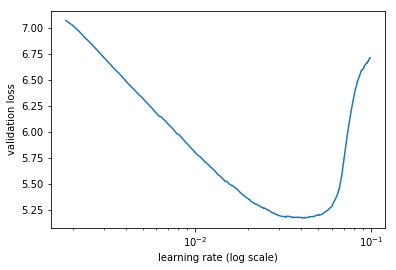

In [551]:
learner.sched.plot()

According to Fastai researchers optimal LR is a biggest value where loss is still significantly decreasing

In [552]:
lr=1e-2
lrs = lr
learner.fit(lrs, 1, wds=wd, cycle_len=30, use_clr_beta=(20,20,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      4.947088   4.679326   0.307522  
    1      4.511131   4.350993   0.331999                   
    2      4.277853   4.208076   0.342493                   
    3      4.115654   4.134334   0.34924                    
    4      4.026613   4.09863    0.35163                    
    5      3.956184   4.099791   0.353058                   
    6      3.931171   4.091969   0.353622                   
    7      3.935735   4.095385   0.352444                   
    8      3.929576   4.111707   0.350784                   
    9      3.93884    4.13081    0.350196                   
    10     3.955302   4.135218   0.349719                   
    11     3.953827   4.157696   0.348985                   
    12     3.955639   4.127703   0.350553                   
    13     3.845221   4.118677   0.352266                   
    14     3.811374   4.086292   0.355444                   
    15     3.741501   4.076504   0.356829

[array([4.06487]), 0.3686575829982758]

In [556]:
learner.save('lmorg_bwd')
learner.save_encoder('lmorg_enc_bwd')

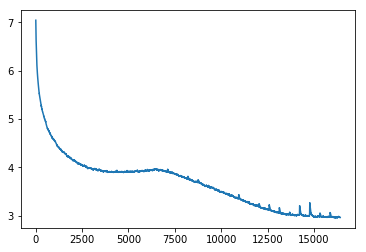

In [557]:
learner.sched.plot_loss()

### BiDirClassifier

In [316]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [317]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [318]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 256

In [319]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [606]:

#Modify the loader class to produce input for both forward and backward models
class BiDirDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, pad_idx=0,
                 num_workers=None, pin_memory=False, drop_last=False, pre_pad=True, half=False,
                 transpose=False, transpose_y=False):
        super().__init__(dataset, batch_size, shuffle, sampler, batch_sampler, pad_idx,
                 num_workers, pin_memory, drop_last, pre_pad, half,
                 transpose, transpose_y)

    def jag_stack(self, b):
        if len(b[0].shape) not in (1,2): return np.stack(b)
        ml = max(len(o) for o in b)
        if min(len(o) for o in b)==ml: return np.stack(b)
        res = np.zeros((len(b), ml), dtype=b[0].dtype) + self.pad_idx
        res_bwd = np.zeros((len(b), ml), dtype=b[0].dtype) + self.pad_idx
        for i,o in enumerate(b):
            res[i, -len(o):] = o
            res_bwd[i, -len(o):] = o[::-1]
        return np.concatenate([res,res_bwd], axis=1)


In [559]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [583]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 0.8 #*0.5

In [584]:

#modify this fastai class to ouput also hidden state
class RNN_Encoder(nn.Module):

    """A custom RNN encoder network that uses
        - an embedding matrix to encode input,
        - a stack of LSTM or QRNN layers to drive the network, and
        - variational dropouts in the embedding and LSTM/QRNN layers

        The architecture for this network was inspired by the work done in
        "Regularizing and Optimizing LSTM Language Models".
        (https://arxiv.org/pdf/1708.02182.pdf)
    """

    initrange=0.1

    def __init__(self, ntoken, emb_sz, nhid, nlayers, pad_token, bidir=False,
                 dropouth=0.3, dropouti=0.65, dropoute=0.1, wdrop=0.5, qrnn=False, bias=False):
        """ Default constructor for the RNN_Encoder class

            Args:
                bs (int): batch size of input data
                ntoken (int): number of vocabulary (or tokens) in the source dataset
                emb_sz (int): the embedding size to use to encode each token
                nhid (int): number of hidden activation per LSTM layer
                nlayers (int): number of LSTM layers to use in the architecture
                pad_token (int): the int value used for padding text.
                dropouth (float): dropout to apply to the activations going from one LSTM layer to another
                dropouti (float): dropout to apply to the input layer.
                dropoute (float): dropout to apply to the embedding layer.
                wdrop (float): dropout used for a LSTM's internal (or hidden) recurrent weights.

            Returns:
                None
          """

        super().__init__()
        self.ndir = 2 if bidir else 1
        self.bs, self.qrnn = 1, qrnn
        self.encoder = nn.Embedding(ntoken, emb_sz, padding_idx=pad_token)
        self.encoder_with_dropout = EmbeddingDropout(self.encoder)
        if self.qrnn:
            #Using QRNN requires cupy: https://github.com/cupy/cupy
            from .torchqrnn.qrnn import QRNNLayer
            self.rnns = [QRNNLayer(emb_sz if l == 0 else nhid, (nhid if l != nlayers - 1 else emb_sz)//self.ndir,
                save_prev_x=True, zoneout=0, window=2 if l == 0 else 1, output_gate=True) for l in range(nlayers)]
            if wdrop:
                for rnn in self.rnns:
                    rnn.linear = WeightDrop(rnn.linear, wdrop, weights=['weight'])
        else:
            self.rnns = [nn.LSTM(emb_sz if l == 0 else nhid, (nhid if l != nlayers - 1 else emb_sz)//self.ndir,
                1, bidirectional=bidir) for l in range(nlayers)]
            if wdrop: self.rnns = [WeightDrop(rnn, wdrop) for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)

        self.emb_sz,self.nhid,self.nlayers,self.dropoute = emb_sz,nhid,nlayers,dropoute
        self.dropouti = LockedDropout(dropouti)
        self.dropouths = nn.ModuleList([LockedDropout(dropouth) for l in range(nlayers)])

    def forward(self, input):
        """ Invoked during the forward propagation of the RNN_Encoder module.
        Args:
            input (Tensor): input of shape (sentence length x batch_size)

        Returns:
            raw_outputs (tuple(list (Tensor), list(Tensor)): list of tensors evaluated from each RNN layer without using
            dropouth, list of tensors evaluated from each RNN layer using dropouth,
        """
        sl,bs = input.size()
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        with set_grad_enabled(self.training):
            emb = self.encoder_with_dropout(input, dropout=self.dropoute if self.training else 0)
            emb = self.dropouti(emb)
            raw_output = emb
            new_hidden,raw_outputs,outputs = [],[],[]
            for l, (rnn,drop) in enumerate(zip(self.rnns, self.dropouths)):
                current_input = raw_output
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    raw_output, new_h = rnn(raw_output, self.hidden[l])
                new_hidden.append(new_h)
                raw_outputs.append(raw_output)
                if l != self.nlayers - 1: raw_output = drop(raw_output)
                outputs.append(raw_output)
            self.hidden = repackage_var(new_hidden)
        return raw_outputs, outputs, new_hidden

    def one_hidden(self, l):
        nh = (self.nhid if l != self.nlayers - 1 else self.emb_sz)//self.ndir
        if IS_TORCH_04: return Variable(self.weights.new(self.ndir, self.bs, nh).zero_())
        else: return Variable(self.weights.new(self.ndir, self.bs, nh).zero_(), volatile=not self.training)

    def reset(self):
        if self.qrnn: [r.reset() for r in self.rnns]
        self.weights = next(self.parameters()).data
        if self.qrnn: self.hidden = [self.one_hidden(l) for l in range(self.nlayers)]
        else: self.hidden = [(self.one_hidden(l), self.one_hidden(l)) for l in range(self.nlayers)]
            
#modify this fastai class to ouput also hidden state           
class MultiBatchRNN(RNN_Encoder):
    def __init__(self, bptt, max_seq, *args, **kwargs):
        self.max_seq,self.bptt = max_seq,bptt
        super().__init__(*args, **kwargs)

    def concat(self, arrs):
        return [torch.cat([l[si] for l in arrs]) for si in range(len(arrs[0]))]

    def forward(self, input):
        sl,bs = input.size()
        for l in self.hidden:
            for h in l: h.data.zero_()
        raw_outputs, outputs = [],[]
        for i in range(0, sl, self.bptt):
            r, o, h = super().forward(input[i: min(i+self.bptt, sl)])
            if i>(sl-self.max_seq):
                raw_outputs.append(r)
                outputs.append(o)
        return self.concat(raw_outputs), self.concat(outputs), h


#create a class which will take as an input two rnns and on top of that will create classifier
class BiDir_Classifier(nn.Module):
    def __init__(self, bptt, max_seq, n_class, n_tok, emb_sz, n_hid, n_layers, pad_token, layers, drops, bidir=False,
                      dropouth=0.3, dropouti=0.5, dropoute=0.1, wdrop=0.5, qrnn=False):
        super().__init__()
        self.rnn1 = MultiBatchRNN(bptt, max_seq, n_tok, emb_sz, n_hid, n_layers, pad_token=pad_token, bidir=bidir,
                      dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop, qrnn=qrnn)
        self.rnn2 = MultiBatchRNN(bptt, max_seq, n_tok, emb_sz, n_hid, n_layers, pad_token=pad_token, bidir=bidir,
                       dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop, qrnn=qrnn)
        self.layers = nn.ModuleList([
            LinearBlock(layers[i], layers[i + 1], drops[i]) for i in range(len(layers) - 1)])
        self.rnn1.reset()
        self.rnn2.reset()
        

    def pool(self, x, bs, is_max):
        f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
        return f(x.permute(1,2,0), (1,)).view(bs,-1)
    
    def forward(self, input):
        l_, _ = input.shape
        half_l = l_//2
        
        r1 = self.rnn1(input[:half_l])
        r2 = self.rnn2(input[half_l:])
        raw_outputs1, outputs1, hiddens1 = r1
        raw_outputs2, outputs2, hiddens2 = r2
        sl,bs,_ = outputs1[-1].size()
        cell1= hiddens1[-1][0].permute(1,2,0).view(bs,-1)
        #cell2= hiddens2[-1][0].permute(1,2,0).view(bs,-1)
        output1 = outputs1[-1]
        output2 = outputs2[-1]
        
        #avgpool1 = self.pool(output1, bs, False)
        #avgpool2 = self.pool(output2, bs, False)
        mxpool1 = self.pool(output1, bs, True)
        mxpool2 = self.pool(output2, bs, True)
        
        #input to the classifier
        x = torch.cat([cell1, mxpool1, mxpool2], 1)
        #x = torch.cat([cl], 1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return l_x, raw_outputs1, outputs1

class TextModel(BasicModel):
    def get_layer_groups(self):
        m = self.model
        return [(m.rnn1.encoder, m.rnn1.dropouti, m.rnn2.encoder, m.rnn2.dropouti), 
                *zip(m.rnn1.rnns, m.rnn1.dropouths, m.rnn2.rnns, m.rnn2.dropouths), (m.layers)]





In [588]:
m = BiDir_Classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])



In [589]:
#Lets create a learner object
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=0.3

metrics = [accuracy]
learn.metrics = metrics

In [590]:
#Fastai practitioners suggest to use different lr for different part of the model
#lrs=np.array([5e-5,5e-5,2e-4,5e-4,1e-3])
lrs=np.array([2e-4,2e-4,1e-3,2e-3,5e-3]) 
#lrs=5e-3
wd = 1e-7

In [591]:
#load the pretrain weights to the encoders
wgts = torch.load(PATH/'models/lmorg_enc.h5', map_location=lambda storage, loc: storage)
wgts2 = torch.load(PATH/'models/lmorg_enc_bwd.h5', map_location=lambda storage, loc: storage)

learn.model.rnn1.load_state_dict(wgts)
learn.model.rnn2.load_state_dict(wgts2)

In [592]:
learn.freeze_to(-1)

epoch      trn_loss   val_loss   accuracy                     
    0      2.141362   1.806615   0.405587  


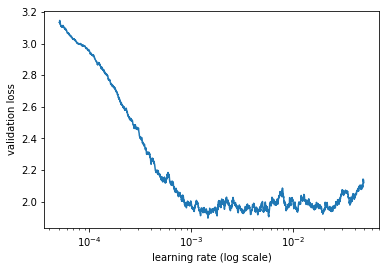

In [569]:
learn.lr_find(lrs/100, lrs*10)
learn.sched.plot()

lr=2e-3
lrm = 5.
lrs = np.array([lr/(lrm**2), lr/(lrm**2), lr/(lrm**2), lr/lrm, lr])
lrs

In [593]:
lrs=np.array([2e-4,2e-4,2e-4,5e-4,1e-3])

In [594]:
learn.fit(lrs, 1, wds=wd, cycle_len=2, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.730444   1.703512   0.449572  
    1      1.684147   1.624644   0.468669                     


[array([1.62464]), 0.4686693521890464]

In [595]:
#learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3)) #0.62

In [596]:
learn.save('clas_0')

In [597]:
learn.load('clas_0')

In [598]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=wd, cycle_len=4, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.67592    1.623278   0.469186  
    1      1.650947   1.575477   0.493032                     
    2      1.564154   1.547327   0.496645                     
    3      1.573564   1.520968   0.505523                     


[array([1.52097]), 0.5055228656524535]

In [599]:
learn.freeze_to(-3)
learn.fit(lrs, 1, wds=wd, cycle_len=4, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.466022   1.530684   0.504594  
    1      1.554721   1.503846   0.511201                     
    2      1.41227    1.512467   0.516259                     
    3      1.465903   1.485863   0.524208                     


[array([1.48586]), 0.5242077009249573]

In [600]:
#oryginal lm - 0.64

In [601]:
learn.save('clas_1')

In [602]:
learn.load('clas_1')

In [603]:
learn.unfreeze()

In [604]:
learn.fit(lrs, 1, wds=wd, cycle_len=8, use_clr_beta=(10,10,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                     
    0      1.423405   1.473954   0.525653  
    1      1.461218   1.495094   0.523588                     
    2      1.397055   1.493352   0.521627                     
    3      1.407238   1.479253   0.527201                     
    4      1.380169   1.470061   0.530402                     
    5      1.436701   1.453107   0.536595                     
    6      1.378989   1.437713   0.540725                     
    7      1.283567   1.485074   0.530298                     


[array([1.48507]), 0.5302983404576465]